# Assignment 3.1 Applying Linear Regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
results_with_confeds = pd.read_csv("results.csv")
results_with_confeds.replace({"Czech Republic": "Czechia"}, inplace=True)
shootouts = pd.read_csv("shootouts.csv")
rankings = pd.read_csv("rankings.csv")
results_with_confeds['date'] = pd.to_datetime(results_with_confeds['date'])
results_with_confeds.insert(5, "score_diff",results_with_confeds['home_score'] - results_with_confeds['away_score'])
shootouts['date'] = pd.to_datetime(shootouts['date'])
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

In [10]:
rankings = pd.read_csv("rankings.csv")
rankings.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,83.0,Guatemala,GUA,15.0,0.0,83,CONCACAF,1992-12-31
1,32.0,Zambia,ZAM,38.0,0.0,32,CAF,1992-12-31
2,33.0,Portugal,POR,38.0,0.0,33,UEFA,1992-12-31
3,34.0,Austria,AUT,38.0,0.0,34,UEFA,1992-12-31
4,35.0,Colombia,COL,36.0,0.0,35,CONMEBOL,1992-12-31


In [74]:
confeds = rankings.drop_duplicates(subset='country_full')[['country_full', 'confederation']]

home_df = confeds.rename(columns={'country_full': 'home_team', 'confederation': 'home_confederation'})
away_df = confeds.rename(columns={'country_full': 'away_team', 'confederation': 'away_confederation'})

results_with_confeds = results_with_confeds.merge(home_df[['home_team', 'home_confederation']], on='home_team', how='left')
results_with_confeds = results_with_confeds.merge(away_df[['away_team', 'away_confederation']], on='away_team', how='left')

In [75]:
rankings = rankings.sort_values(by=['country_full', 'rank_date'])

rankings_home = rankings.rename(columns={'country_full': 'home_team', 'rank': 'home_ranking', 'rank_date': 'home_ranking_date'})
results_with_confeds = pd.merge_asof(results_with_confeds.sort_values('date'),
                           rankings_home.sort_values('home_ranking_date'),
                           left_on='date',
                           right_on='home_ranking_date',
                           by='home_team',
                           direction='backward')

rankings_away = rankings.rename(columns={'country_full': 'away_team', 'rank': 'away_ranking', 'rank_date': 'away_ranking_date'})
results_with_confeds = pd.merge_asof(results_with_confeds.sort_values('date'),
                           rankings_away.sort_values('away_ranking_date'),
                           left_on='date',
                           right_on='away_ranking_date',
                           by='away_team',
                           direction='backward')

In [76]:
results_with_rankings = results_with_confeds.drop(columns=['country_abrv_x', 'total_points_x', 'previous_points_x',
       'rank_change_x', 'confederation_x', 'home_ranking_date', 'country_abrv_y', 'total_points_y', 'previous_points_y',
       'rank_change_y', 'confederation_y', 'away_ranking_date', 'city', 'country'])

results_with_rankings = results_with_rankings.dropna()

results_with_rankings = results_with_rankings.drop(columns=["home_team", "away_team", "tournament", "neutral", "home_confederation", "away_confederation"])

results_with_rankings

,date,home_score,away_score,score_diff,home_ranking,away_ranking
18663,1993-01-01,1.0,1.0,0.0,39.0,69.0
18664,1993-01-02,1.0,1.0,0.0,55.0,97.0
18665,1993-01-02,2.0,0.0,2.0,71.0,161.0
18666,1993-01-03,1.0,0.0,1.0,97.0,69.0
18667,1993-01-03,2.0,3.0,-1.0,55.0,39.0
...,...,...,...,...,...,...
47262,2024-06-11,1.0,1.0,0.0,67.0,80.0
47263,2024-06-11,3.0,1.0,2.0,154.0,182.0
47264,2024-06-11,4.0,0.0,4.0,150.0,207.0
47265,2024-06-11,2.0,1.0,1.0,34.0,121.0


## Question: Is a team's FIFA world ranking indicative of their ability to score goals?
### Hypothesis: The higher the team's ranking (closer to 1), the more goals they score on average.

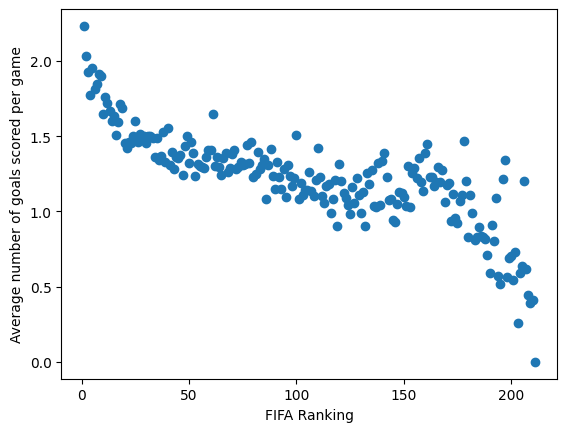

In [104]:
def get_average_goals(ranking):
    return (results_with_rankings[results_with_rankings['home_ranking']==ranking]['home_score'].mean() 
    + results_with_rankings[results_with_rankings['away_ranking']==ranking]['away_score'].mean())/2

unique_rankings = rankings['rank'].unique()

x = np.array(list(sorted(unique_rankings[~np.isnan(unique_rankings)])))
y = np.array([get_average_goals(rank) for rank in x])

plt.plot(x,y, 'o')
plt.xlabel("FIFA Ranking")
plt.ylabel("Average number of goals scored per game")
plt.show()

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = x.reshape(-1, 1)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

(0.6833709236430114, 0.027269271562452672)